# DataJoint Element for Motion Sequencing with Keypoint MoSeq


#### **Open-source Data Pipeline for Motion Sequencing in Neurophysiology**


Welcome to the tutorial for the DataJoint Element for motion sequencing analysis. This tutorial aims to provide a comprehensive understanding of the open-source data pipeline by `element-moseq`.


![pipeline](../images/flowchart.svg)


The package is designed to seamlessly integrate the **PCA fitting**, **model fitting** through **initialization**, **fitting an AR-HMM**, and **fitting the full model** into a data pipeline and streamline model and video management using DataJoint.


![pipeline](../images/pipeline.svg)


By the end of this tutorial, you will have a clear grasp of how to set up and integrate the `Element MoSeq` into your specific research projects and your lab.


### Prerequisites

Please see the [datajoint tutorials GitHub repository](https://github.com/datajoint/datajoint-tutorials/tree/main) proceeding.
A basic understanding of the following DataJoint concepts will be beneficial to your understanding of this tutorial:

1. The `Imported` and `Computed` tables types in `datajoint-python`.
2. The functionality of the `.populate()` method.


#### **Tutorial Overview**


- Setup
- _Activate_ the DataJoint pipeline
- _Insert_ example data into subject and session tables
- _Insert_ the keypoint data from pose estimation and the body parts in the DataJoint pipeline
- _Fit a PCA model_ to aligned and centered keypoint coordinates and _select_ the latent dimension
- _Fit the AR-HMM and the full model_
- _Generate and store_ the model results and visualizations


### **Setup**


This tutorial loads the keypoint data extracted by DeepLabCut of a single freely moving mouse in an open-field environment. The goal is to link this point tracking to pose dynamics by identifying its behavioral modules ("syllables") without human supervision. The modeling results are stored as a `.h5` file (and optionally a directory of `.csv` files) that contain the following information:

- Behavior modules as "syllables": the syllable label assigned to each frame (i.e. the state indexes assigned by the model)
- Centroid and heading in each frame, as estimated by the model, that capture the animal's overall position in allocentric coordinates
- Latent state: low-dimensional representation of the animal's pose in each frame. These are similar to PCA scores, are modified to reflect the pose dynamics and noise estimates inferred by the model.

The results of this Element example can be combined with **other modalities** to create a complete customizable data pipeline for your specific lab or study. For instance, you can combine `element-moseq` with `element-deeplabcut` and `element-calcium-imaging` to characterize the neural activity along with natural sub-second rhythmicity in mouse movement.

#### Steps to Run the Element-MoSeq

The input data for this data pipeline is as follows:

- A DeepLabCut (DLC) project folder with its config file, video set and keypoint data.
- Selection of the anterior, posterior, and use bodyparts.
  This tutorial includes this DLC project folder with example data and the results as well in `example_data` directory.


Let's start this tutorial by importing the packages necessary to run the data pipeline.


In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
from pathlib import Path
import numpy as np

If the tutorial is run in Codespaces, a private, local database server is created and made available for you. This is where we will insert and store our processed results.

Let's connect to the database server.


In [3]:
dj.conn()

[2024-03-13 17:32:11,291][INFO]: Connecting root@localhost:3306
[2024-03-13 17:32:11,319][INFO]: Connected root@localhost:3306


DataJoint connection (connected) root@localhost:3306

### **Activate the DataJoint pipeline**


This tutorial presumes that the `element-moseq` has been pre-configured and instantiated, with the database linked downstream to pre-existing `subject` and `session` tables. Please refer to the `tutorial_pipeline.py` for the source code.

Now, we will proceed to import the essential schemas required to construct this data pipeline, with particular attention to the primary components: `kpms_pca` and `kpms_model`.


In [4]:
from tutorial_pipeline import lab, subject, session, kpms_pca, kpms_model

[2024-03-13 17:32:11,328][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the tables in the `kpms_pca` and `kpms_model` schemas as well as some of the upstream dependencies to `session` and `subject` schemas as a diagram.


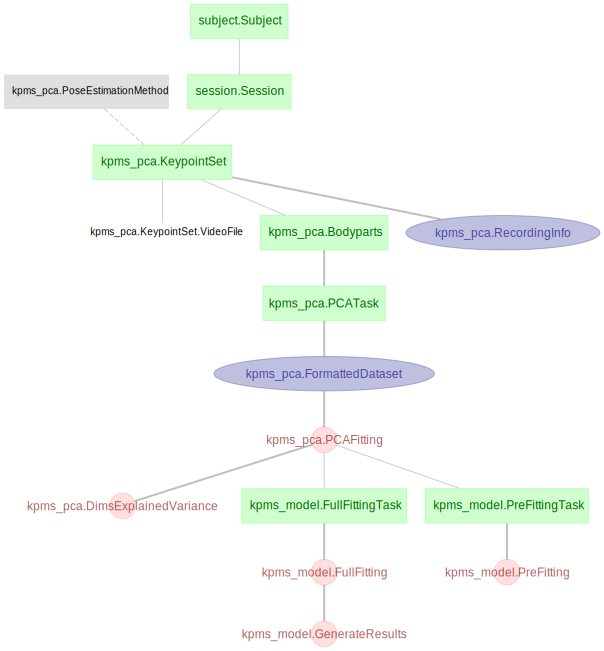

In [5]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(kpms_pca)
    + dj.Diagram(kpms_model)
)

As evident from the diagram, this data pipeline encompasses several tables associated with different keypoint-MoSeq components like pca, pre-fitting of AR-HMM, and full fitting of the model. A few tables, such as `subject.Subject` or `session.Session`, while important for a complete pipeline, fall outside the scope of the `element-moseq` tutorial, and will therefore, not be explored extensively here. The primary focus of this tutorial will be on the `kpms_pca` and `kpms_model` schemas.


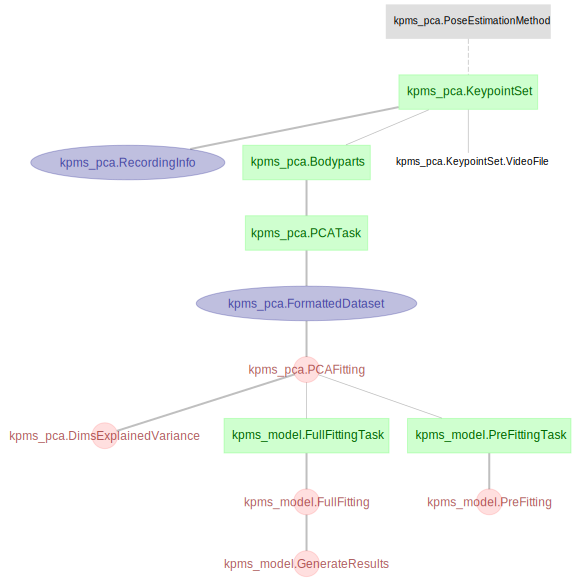

In [6]:
(
    dj.Diagram(kpms_pca)
    + dj.Diagram(kpms_model)
)

### Insert example data into subject and session tables


Let's delve into the `subject.Subject` and `session.Session` tables and include some example data.


In [7]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,,F,2020-01-01,test


Add a new entry for a subject in the `Subject` table:


In [8]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="F",
        subject_birth_date="2020-01-01",
        subject_description="test",
    ),
    skip_duplicates=True,
)

Create session keys and input them into the `Session` table:


In [9]:
# Definition of the dictionary named "session_keys"
session_keys = [
    dict(subject="subject1", session_datetime="2021-06-02 14:04:22"),
    dict(subject="subject1", session_datetime="2021-06-03 14:43:10"),
]

# Insert this dictionary in the Session table
session.Session.insert(session_keys, skip_duplicates=True)

Confirm the inserted data:


In [10]:
session.Session()

subject,session_datetime
subject1,2021-06-02 14:04:22
subject1,2021-06-03 14:43:10


### Insert the keypoint data from pose estimation and the body parts in the DataJoint pipeline


In [11]:
kpms_pca.PoseEstimationMethod()

"format_method deeplabcut, sleap, anipose, sleap-anipose, nwb, facemap,",pose_estimation_desc Optional. Pose estimation method description
anipose,`.csv` files generated by anipose analysis
deeplabcut,`.csv` and `.h5/.hdf5` files generated by DeepLabcut analysis
facemap,`.h5` files generated by Facemap analysis
nwb,`.nwb` files with Neurodata Without Borders (NWB) format
sleap,`.slp` and `.h5/.hdf5` files generated by SLEAP analysis
sleap-anipose,`.h5/.hdf5` files generated by sleap-anipose analysis


In [12]:
kpset_key = dict(subject="subject1", session_datetime="2021-06-02 14:04:22", kpset_id=1)

kpms_pca.KeypointSet.insert1(
    {
        **kpset_key,
        "format_method": "deeplabcut",
        "kpset_config_dir": "/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data",
        "kpset_videos_dir": "/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data/videos",
        "kpset_desc": "testing kpms pca schema",
    },
    skip_duplicates=True,
)

In [13]:
kpms_pca.KeypointSet()

subject,session_datetime,kpset_id,"format_method deeplabcut, sleap, anipose, sleap-anipose, nwb, facemap,",kpset_config_dir Path relative to root data directory where the config file is located,kpset_videos_dir Path relative to root data directory where the videos and their keypoints are located,kpset_desc Optional. User-entered description
subject1,2021-06-02 14:04:22,1,deeplabcut,/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data,/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data/videos,testing kpms pca schema


In [14]:
video_files = [
    "/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data/videos/21_11_8_one_mouse.top.ir.Mp4",
    "/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data/videos/21_12_2_def6a_1.top.ir.mp4",
    "/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data/videos/21_12_2_def6b_2.top.ir.mp4",
]

kpms_pca.KeypointSet.VideoFile.insert(
    (
        {**kpset_key, "video_id": v_idx, "video_path": Path(f)}
        for v_idx, f in enumerate(video_files)
    ),
    skip_duplicates=True,
)

In [15]:
kpms_pca.KeypointSet.VideoFile()

subject,session_datetime,kpset_id,video_id,"video_path Filepath of each video, relative to root data directory"
subject1,2021-06-02 14:04:22,1,0,/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data/videos/21_11_8_one_mouse.top.ir.Mp4
subject1,2021-06-02 14:04:22,1,1,/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data/videos/21_12_2_def6a_1.top.ir.mp4
subject1,2021-06-02 14:04:22,1,2,/Users/milagros/Documents/datajoint-elements/element-moseq/data/inbox/input_data/videos/21_12_2_def6b_2.top.ir.mp4


In [16]:
kpms_pca.RecordingInfo()

subject,session_datetime,kpset_id,px_height_average Average height of the video set (pixels),px_width_average Average width of the video set (pixels),nframes_average Average number of frames of the video set (frames),fps_average Optional. Average frames per second of the video set (Hz),recording_duration_average Average video duration (s) of the video set (nframes / fps)


In [17]:
kpms_pca.RecordingInfo.populate()

In [18]:
kpms_pca.RecordingInfo()

subject,session_datetime,kpset_id,px_height_average Average height of the video set (pixels),px_width_average Average width of the video set (pixels),nframes_average Average number of frames of the video set (frames),fps_average Optional. Average frames per second of the video set (Hz),recording_duration_average Average video duration (s) of the video set (nframes / fps)
subject1,2021-06-02 14:04:22,1,576,640,95517,30,3183.0


In [19]:
kpms_pca.Bodyparts()

subject,session_datetime,kpset_id,bodyparts_id,bodyparts_desc Optional. User-entered description.,anterior_bodyparts List of strings of anterior bodyparts,posterior_bodyparts List of strings of posterior bodyparts,use_bodyparts List of strings of bodyparts to be used


In [20]:
bodypart_key = {**kpset_key, "bodyparts_id": 1}
kpms_pca.Bodyparts.insert1(
    {
        **bodypart_key,
        "anterior_bodyparts": ["nose"],
        "posterior_bodyparts": ["spine4"],
        "use_bodyparts": [
            "spine4",
            "spine3",
            "spine2",
            "spine1",
            "head",
            "nose",
            "right ear",
            "left ear",
        ],
    },
    skip_duplicates=True,
)

In [21]:
kpms_pca.Bodyparts()

subject,session_datetime,kpset_id,bodyparts_id,bodyparts_desc Optional. User-entered description.,anterior_bodyparts List of strings of anterior bodyparts,posterior_bodyparts List of strings of posterior bodyparts,use_bodyparts List of strings of bodyparts to be used
subject1,2021-06-02 14:04:22,1,1,,=BLOB=,=BLOB=,=BLOB=


### Fit a PCA model to aligned and centered keypoint coordinates and select the latent dimension


In [22]:
kpms_pca.PCATask()

subject,session_datetime,kpset_id,bodyparts_id,output_dir KPMS's output directory relative to root,"task_mode default = 'load': load computed analysis results, 'trigger': trigger computation"


In [23]:
kpms_pca.PCATask.insert1(
    {
        **bodypart_key,
        "output_dir": "/Users/milagros/Documents/datajoint-elements/element-moseq/data/outbox/kpms_project_tutorial",
        "task_mode": "trigger",
    },
    skip_duplicates=True,
)

In [24]:
kpms_pca.PCATask()

subject,session_datetime,kpset_id,bodyparts_id,output_dir KPMS's output directory relative to root,"task_mode default = 'load': load computed analysis results, 'trigger': trigger computation"
subject1,2021-06-02 14:04:22,1,1,/Users/milagros/Documents/datajoint-elements/element-moseq/data/outbox/kpms_project_tutorial,trigger


In [25]:
key = (kpms_pca.PCATask & "task_mode = 'trigger'").fetch1("KEY")
key

{'subject': 'subject1',
 'session_datetime': datetime.datetime(2021, 6, 2, 14, 4, 22),
 'kpset_id': 1,
 'bodyparts_id': 1}

In [26]:
kpms_pca.FormattedDataset()

subject,session_datetime,kpset_id,bodyparts_id,coordinates Keypoint coordinates,confidences Keypoint confidences,formatted_bodyparts Formatted bodyparts


In [27]:
kpms_pca.FormattedDataset.populate(key)

The directory `/Users/milagros/Documents/datajoint-elements/element-
moseq/data/outbox/kpms_project_tutorial` already exists. Use
`overwrite=True` or pick a different name
ACTION REQUIRED: `anterior_bodyparts` contains BODYPART1 which is not
  one of the options in `use_bodyparts`.

ACTION REQUIRED: `posterior_bodyparts` contains BODYPART3 which is not
  one of the options in `use_bodyparts`.



Loading keypoints: 100%|████████████████| 10/10 [00:00<00:00, 28.63it/s]


In [28]:
kpms_pca.FormattedDataset()

subject,session_datetime,kpset_id,bodyparts_id,coordinates Keypoint coordinates,confidences Keypoint confidences,formatted_bodyparts Formatted bodyparts
subject1,2021-06-02 14:04:22,1,1,=BLOB=,=BLOB=,=BLOB=


The `PCAFitting` computation will fit a PCA model to aligned and centered keypoint coordinates


In [29]:
kpms_pca.PCAFitting()

subject,session_datetime,kpset_id,bodyparts_id,pca_fitting_time Time of generation of the PCA fitting analysis


In [30]:
kpms_pca.PCAFitting.populate(key)

In [31]:
kpms_pca.PCAFitting()

subject,session_datetime,kpset_id,bodyparts_id,pca_fitting_time Time of generation of the PCA fitting analysis
subject1,2021-06-02 14:04:22,1,1,2024-03-13 16:32:23


In [32]:
kpms_pca.DimsExplainedVariance()

subject,session_datetime,kpset_id,bodyparts_id,variance_percentage Percentage of variance explained by the selected components.,dims_explained_variance Number of components required to explain the specified variance.,latent_dim_desc Description of the latent dimensions that explain the specified variance.


In [33]:
kpms_pca.DimsExplainedVariance.populate(key)

In [34]:
kpms_pca.DimsExplainedVariance()

subject,session_datetime,kpset_id,bodyparts_id,variance_percentage Percentage of variance explained by the selected components.,dims_explained_variance Number of components required to explain the specified variance.,latent_dim_desc Description of the latent dimensions that explain the specified variance.
subject1,2021-06-02 14:04:22,1,1,90.0,4,>=90.0% of variance explained by 4 components.


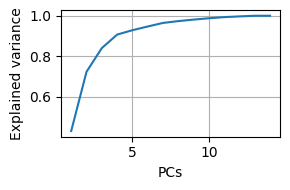

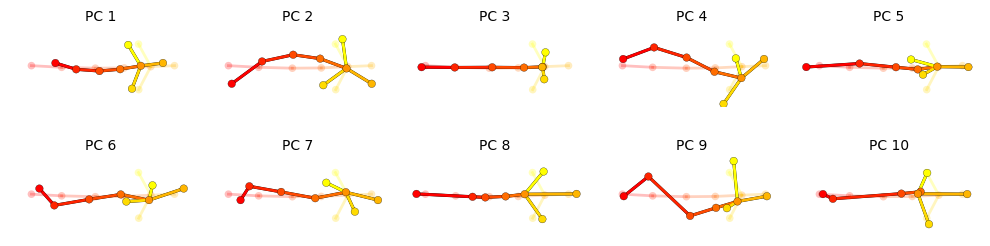

In [35]:
# Plotting before the user's choice of the latent dimensions to use in the next step
from keypoint_moseq import load_pca, plot_scree, plot_pcs
from element_moseq.readers.kpms_reader import load_dj_config

output_dir = (kpms_pca.PCATask & key).fetch1("output_dir")
config = load_dj_config(output_dir, check_if_valid=False, build_indexes=False)

pca = load_pca(output_dir)

plot_scree(pca, project_dir=output_dir)
plot_pcs(pca, project_dir=output_dir, **config)

### Fit the AR-HMM and the full model


KPMS Model prefitting and full fitting involves:

1. **Initialization**: Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA
2. **Fitting an AR-HMM**: AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling
3. **Fitting the full model**: all params, including both AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. pose trajectories) are iteratively updated through Gibss sampling. Step useful for noisy data.
4. **Extracting model results**: the learned states of the model are parsed and saved to disk for visualization and downstream analysis.


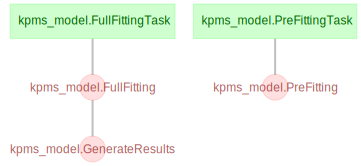

In [36]:
dj.Diagram(kpms_model)

Adjust `kappa` hyperparameter to achieve the desired distribution of syllable durations. Higher values of kappa lead to longer syllables.

Let's chose a kappa value that yields a median syllable duration of 12 frames.


In [37]:
fps = (kpms_pca.RecordingInfo & key).fetch1("fps_average")
kappa_min = (12 / fps) * 1000 #ms
kappa_max = 1e6 #ms 
kappa_range = np.logspace(np.log10(kappa_min), np.log10(kappa_max), num=3)
print('kappa range = {} ms'.format(kappa_range))


kappa range = [4.e+02 2.e+04 1.e+06] ms


For rodents it's recommended a target duration of ~400ms


The kappa value in the config is only used during model initialization.


In [38]:
prefitting_keys = [{
    **key,
    'pre_latent_dim': 4,
    'pre_kappa': int(i),
    'pre_num_iterations': 2,
    'pre_fitting_desc': f"Prefitting {c}",
    'model_initialization': 'Yes',
} for c, i in enumerate(kappa_range, start=1)]

prefitting_keys

[{'subject': 'subject1',
  'session_datetime': datetime.datetime(2021, 6, 2, 14, 4, 22),
  'kpset_id': 1,
  'bodyparts_id': 1,
  'pre_latent_dim': 4,
  'pre_kappa': 400,
  'pre_num_iterations': 2,
  'pre_fitting_desc': 'Prefitting 1',
  'model_initialization': 'Yes'},
 {'subject': 'subject1',
  'session_datetime': datetime.datetime(2021, 6, 2, 14, 4, 22),
  'kpset_id': 1,
  'bodyparts_id': 1,
  'pre_latent_dim': 4,
  'pre_kappa': 20000,
  'pre_num_iterations': 2,
  'pre_fitting_desc': 'Prefitting 2',
  'model_initialization': 'Yes'},
 {'subject': 'subject1',
  'session_datetime': datetime.datetime(2021, 6, 2, 14, 4, 22),
  'kpset_id': 1,
  'bodyparts_id': 1,
  'pre_latent_dim': 4,
  'pre_kappa': 1000000,
  'pre_num_iterations': 2,
  'pre_fitting_desc': 'Prefitting 3',
  'model_initialization': 'Yes'}]

In [39]:
kpms_model.PreFittingTask.insert(prefitting_keys, skip_duplicates=True)

In [40]:
kpms_model.PreFittingTask()

subject,session_datetime,kpset_id,bodyparts_id,pre_latent_dim,pre_kappa,pre_num_iterations,pre_fitting_desc,"model_initialization 'Yes' initialize a new AR-HMM model and output_dir, 'No' will directly pre-fit the model",model_name_initialization Optional. Name of the initialized model to be pre-fitted. Only needed if model_initialization = False
subject1,2021-06-02 14:04:22,1,1,4,400,2,Prefitting 1,Yes,
subject1,2021-06-02 14:04:22,1,1,4,20000,2,Prefitting 2,Yes,
subject1,2021-06-02 14:04:22,1,1,4,1000000,2,Prefitting 3,Yes,


In [41]:
kpms_model.PreFitting()

subject,session_datetime,kpset_id,bodyparts_id,pre_latent_dim,pre_kappa,pre_num_iterations,model_name Name of the model,pre_fitting_duration Duration of generation of the full fitting model


/Users/milagros/miniconda/envs/kpms_test/lib/python3.9/site-packages/keypoint_moseq/fitting.py:589: UserWarning:

'kappa' with <class 'int'> will be cast to <class 'float'>



Outputs will be saved to /Users/milagros/Documents/datajoint-
elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_13-17_32_42


 67%|████████████████████████▋            | 2/3 [00:28<00:13, 13.85s/it]

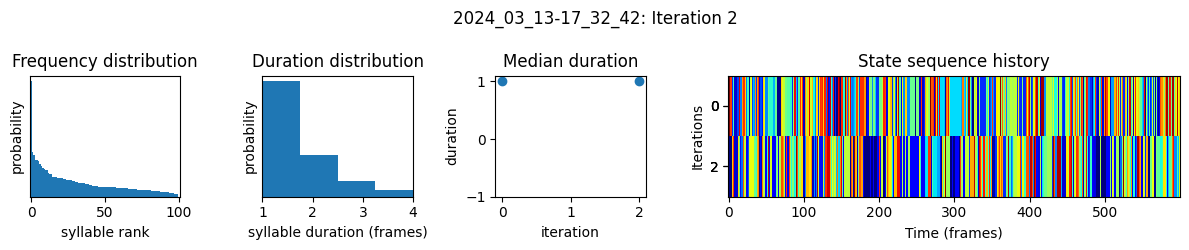

100%|█████████████████████████████████████| 3/3 [00:40<00:00, 13.56s/it]


Outputs will be saved to /Users/milagros/Documents/datajoint-
elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_13-17_33_31


 67%|████████████████████████▋            | 2/3 [00:09<00:04,  4.53s/it]

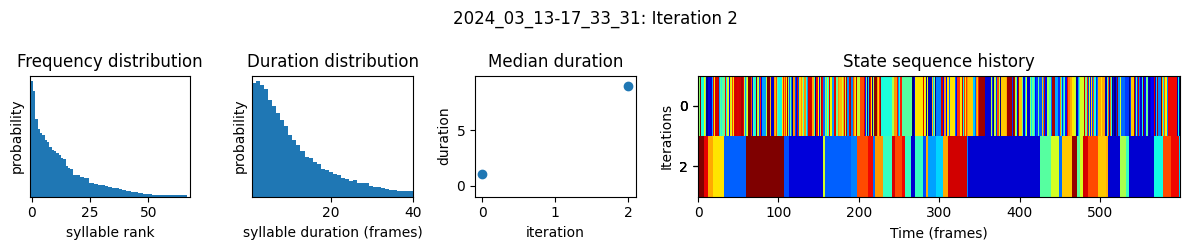

100%|█████████████████████████████████████| 3/3 [00:13<00:00,  4.48s/it]


Outputs will be saved to /Users/milagros/Documents/datajoint-
elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_13-17_33_50


 67%|████████████████████████▋            | 2/3 [00:07<00:03,  3.73s/it]

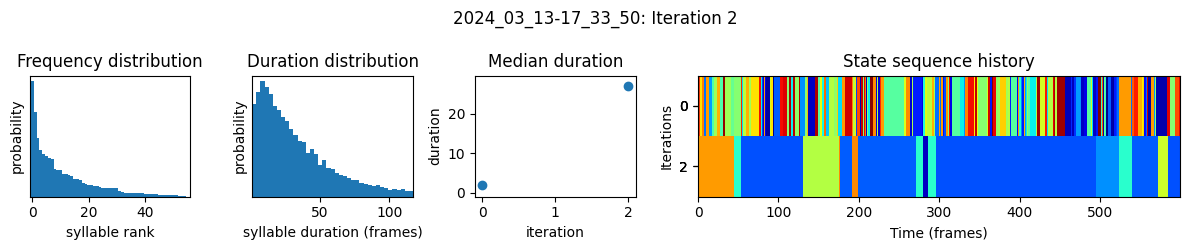

100%|█████████████████████████████████████| 3/3 [00:11<00:00,  3.87s/it]


In [42]:
kpms_model.PreFitting.populate(key)

In [43]:
kpms_model.PreFitting()

subject,session_datetime,kpset_id,bodyparts_id,pre_latent_dim,pre_kappa,pre_num_iterations,model_name Name of the model,pre_fitting_duration Duration of generation of the full fitting model
subject1,2021-06-02 14:04:22,1,1,4,400,2,2024_03_13-17_32_42,0:00:40
subject1,2021-06-02 14:04:22,1,1,4,20000,2,2024_03_13-17_33_31,0:00:13
subject1,2021-06-02 14:04:22,1,1,4,1000000,2,2024_03_13-17_33_50,0:00:11


In [44]:
kpms_model.FullFittingTask()

subject,session_datetime,kpset_id,bodyparts_id,full_latent_dim,full_kappa,full_num_iterations,full_fitting_desc,"task_mode 'trigger' train a new full model, 'load' use an existing model and apply it to a different keypoint formatted data and pca",sort_syllables Whether to sort syllables by frequency (reindexing),results_as_csv Whether to save results as csv (Optional),visualizations Whether to save visualizations (Optional)


In [45]:
fullfitting_key = ({**key,
                      'full_latent_dim': 4,
                      'full_kappa': 1000000,
                      'full_num_iterations':6,
                      'full_fitting_desc':"Full fitting model and generate results and visualizations",
                      'task_mode':'trigger',
                      'sort_syllables':True,
                      'results_as_csv':True,
                      'visualizations':True})

kpms_model.FullFittingTask.insert1(fullfitting_key, skip_duplicates=True)                                  

In [46]:
kpms_model.FullFittingTask()

subject,session_datetime,kpset_id,bodyparts_id,full_latent_dim,full_kappa,full_num_iterations,full_fitting_desc,"task_mode 'trigger' train a new full model, 'load' use an existing model and apply it to a different keypoint formatted data and pca",sort_syllables Whether to sort syllables by frequency (reindexing),results_as_csv Whether to save results as csv (Optional),visualizations Whether to save visualizations (Optional)
subject1,2021-06-02 14:04:22,1,1,4,1000000,6,Full fitting model and generate results and visualizations,trigger,1,1,1


Outputs will be saved to /Users/milagros/Documents/datajoint-
elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_13-17_33_50


 80%|█████████████████████████████▌       | 4/5 [01:21<00:18, 18.81s/it]

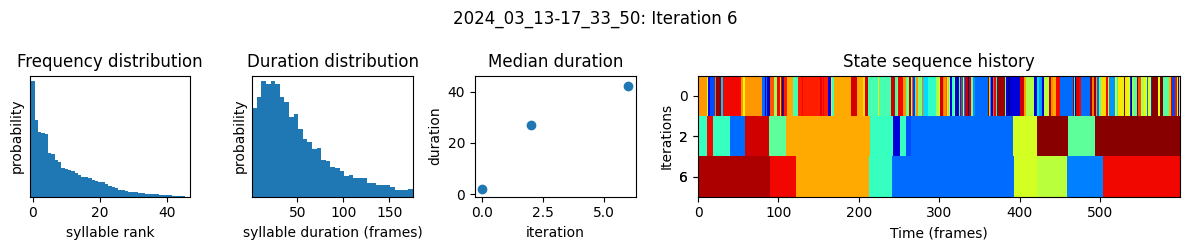

100%|█████████████████████████████████████| 5/5 [01:40<00:00, 20.03s/it]


In [47]:
kpms_model.FullFitting.populate()

In [48]:
kpms_model.FullFitting()

subject,session_datetime,kpset_id,bodyparts_id,full_latent_dim,full_kappa,full_num_iterations,full_fitting_duration Duration of generation of the full fitting model
subject1,2021-06-02 14:04:22,1,1,4,1000000,6,0:01:40


### Generate and store the model results and visualizations


Reindexing: 100%|█████████████| 3/3 [00:00<00:00,  9.18model snapshot/s]


Saved results to /Users/milagros/Documents/datajoint-elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_13-17_33_50/results.h5


Saving to csv: 100%|████████████████████| 10/10 [00:01<00:00,  6.60it/s]


Saving trajectory plots to /Users/milagros/Documents/datajoint-elements/element-moseq/data/outbox/kpms_project_tutorial/2024_03_13-17_33_50/trajectory_plots


Generating trajectory plots: 100%|██████| 29/29 [00:06<00:00,  4.34it/s]


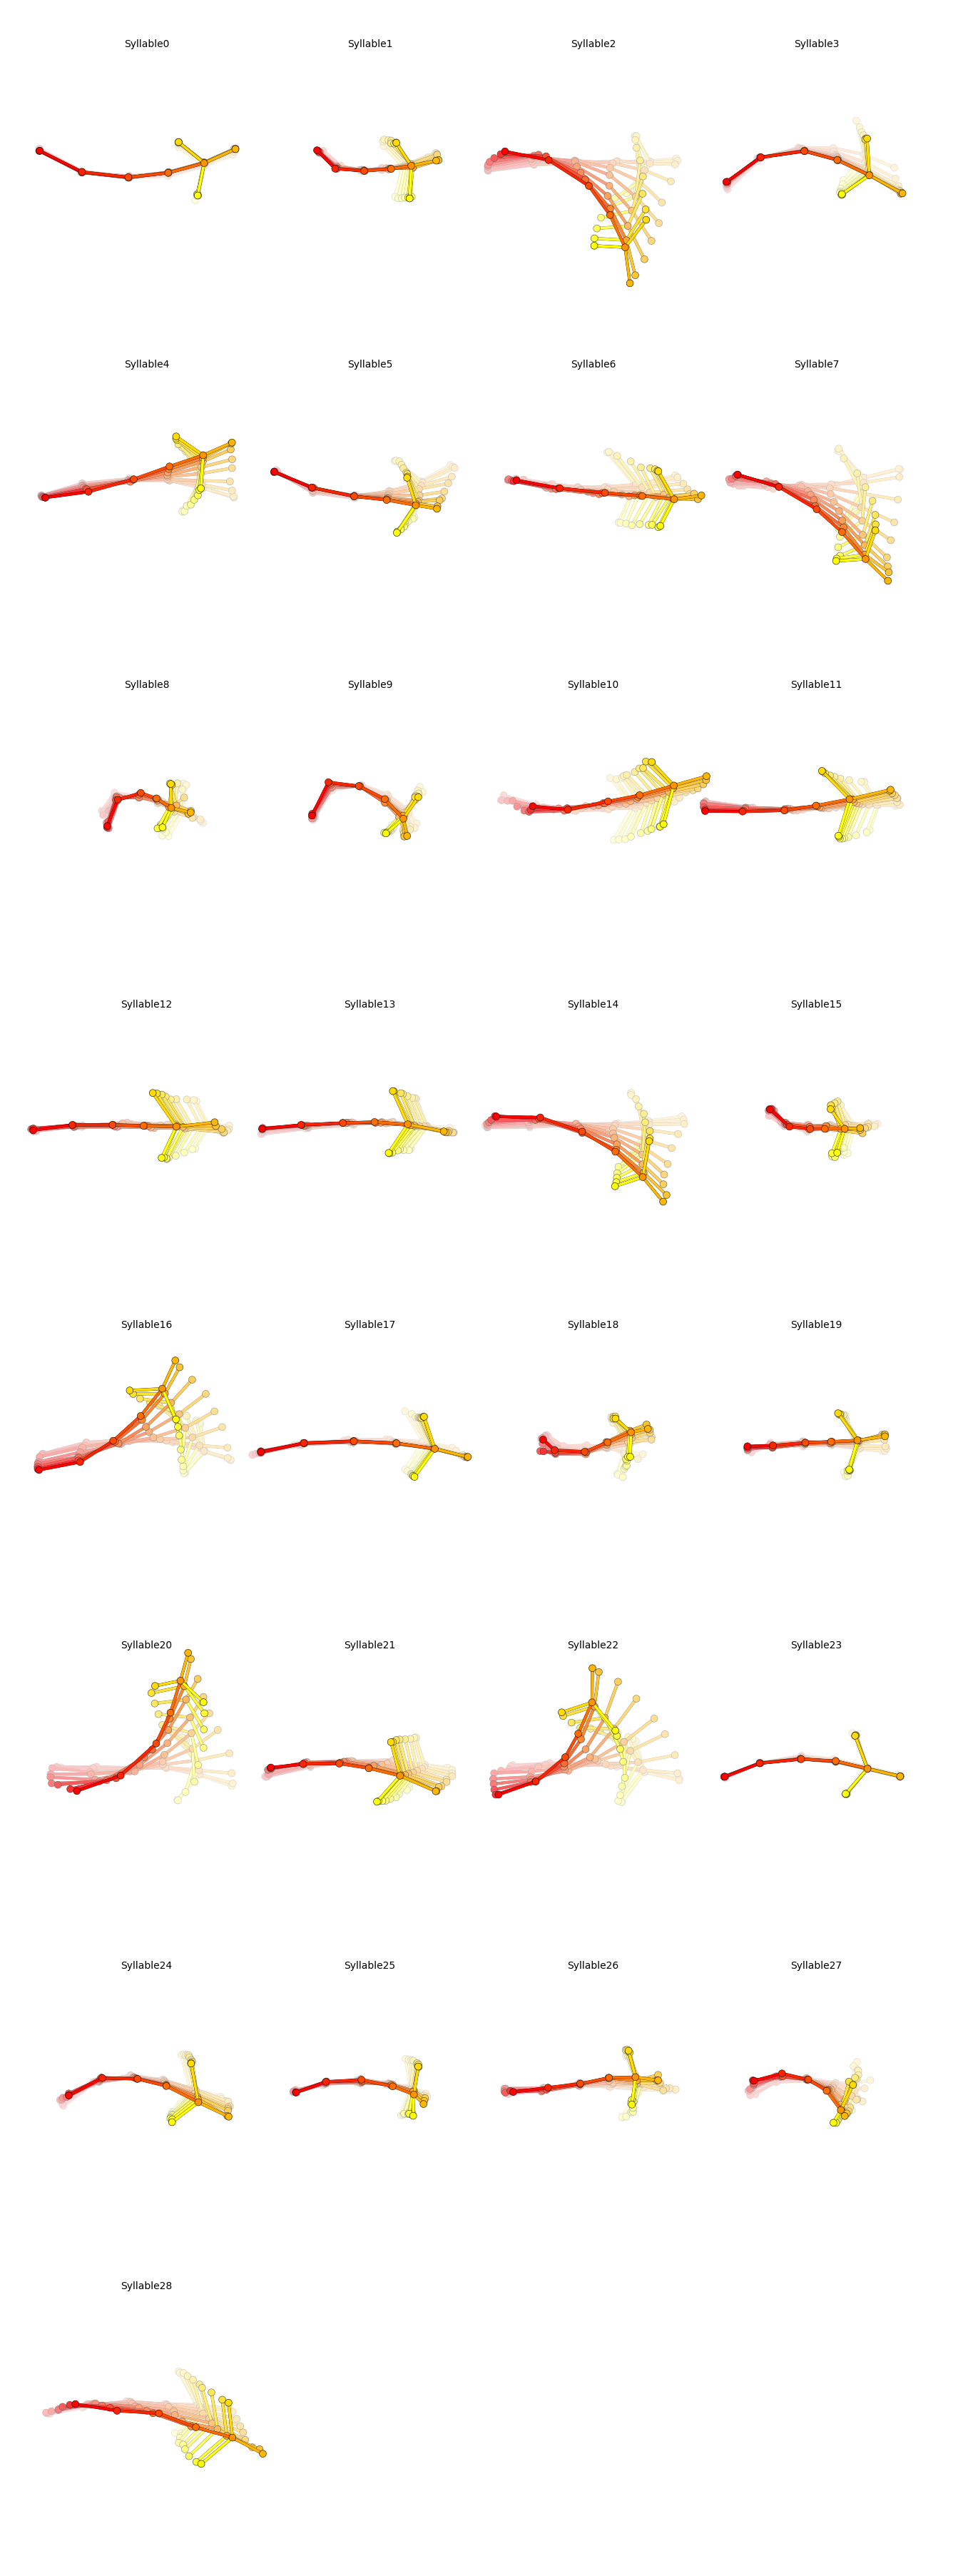

Writing grid movies to /Users/milagros/Documents/datajoint-elements/element-moseq/data/outbox/kpms_project_tutorial/2024_03_13-17_33_50/grid_movies
Using window size of 128 pixels


Generating grid movies: 100%|███████████| 30/30 [00:59<00:00,  2.00s/it]


Saving dendrogram plot to /Users/milagros/Documents/datajoint-elements/element-moseq/data/outbox/kpms_project_tutorial/2024_03_13-17_33_50/similarity_dendrogram


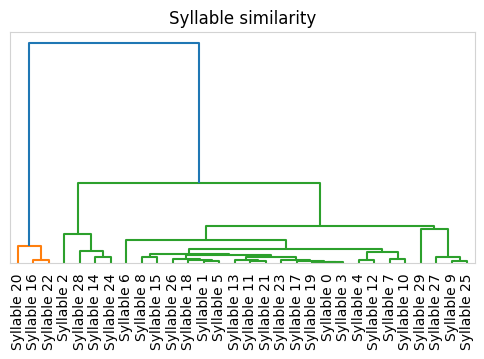

In [49]:
kpms_model.GenerateResults.populate()